# Prediction of Call Volume for Seattle Fire Department

### 1. Problem definition

    How well can we predict the amount of calls per hour and per day for Seattle Fire Department

### 2. Data

The data is downloaded from the dataset of 911 calls at data_Seattle_gov: https://data.seattle.gov/Public-Safety/Seattle-Real-Time-Fire-911-Calls/kzjm-xkqj

I made them in three main datasets:

  - The training set, which contains data of years: 2016, 2017, 2018 and 2019.
  - The validation set, which contains data of year: 2020
  - The test set, which contains data of year: 2021

### 3. Evaluation

The evaluation metric for this project is the RMSLE (root mean squared log error) between the actual and predicted amount of calls and also backtesting plot.



  > Note: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import datetime as dt
import json
import os

In [27]:
# import our data
df = pd.read_csv("Seattle_Real_Time_Fire_911_Calls.csv",
                 parse_dates=["Datetime"])

# Getting Data ready

### separate the part of data that we need

   -  At the first step we separate the data from 2016 to 2021
   -  Because in this project the exact address of calls are not important, we remove the columns contains information of address
   -  We check if we have some missing data or non numerical data
   -  Make separated columns of 'Datetime' column and order them by time

        

In [28]:
# removing adress information
df = df.drop(['Address', 'Type', 'Latitude', 'Longitude', 'Report Location', 'Incident Number'] , axis=1)

In [29]:
# select the period of time that we need (2016 - 2021)
df = df [(df['Datetime']>='2016-01-01') & (df['Datetime']<'2022-01-01')]

In [30]:
# check if there is any missing data
df.isna().sum()

Datetime    0
dtype: int64

In [31]:
# order the 'Datetime' column by time and extract 'year', 'month', 'Day_of_week', 'day_of_month', 'day_of_year' and 'hour' from it.

df["Datetime"] = pd.to_datetime(df["Datetime"])
df= df.sort_values(by=["Datetime"], ascending=True)

df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day-of-week'] = df['Datetime'].dt.dayofweek
df['Day-of-month'] = df['Datetime'].dt.day
df['Day-of-year'] = df['Datetime'].dt.dayofyear
df['Hour'] = df['Datetime'].dt.hour

In [32]:
# check the type of our data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609306 entries, 1022531 to 1651967
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Datetime      609306 non-null  datetime64[ns]
 1   Year          609306 non-null  int64         
 2   Month         609306 non-null  int64         
 3   Day-of-week   609306 non-null  int64         
 4   Day-of-month  609306 non-null  int64         
 5   Day-of-year   609306 non-null  int64         
 6   Hour          609306 non-null  int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 37.2 MB


In [33]:
# look at data
df.head(10)

,Datetime,Year,Month,Day-of-week,Day-of-month,Day-of-year,Hour
1022531,2016-01-01 00:05:37,2016,1,4,1,1,0
1022532,2016-01-01 00:10:49,2016,1,4,1,1,0
1022533,2016-01-01 00:18:36,2016,1,4,1,1,0
1022534,2016-01-01 00:19:11,2016,1,4,1,1,0
1022535,2016-01-01 00:24:02,2016,1,4,1,1,0
1022536,2016-01-01 00:29:03,2016,1,4,1,1,0
1022537,2016-01-01 00:29:48,2016,1,4,1,1,0
1022538,2016-01-01 00:29:58,2016,1,4,1,1,0
1022539,2016-01-01 00:33:55,2016,1,4,1,1,0
1022540,2016-01-01 00:36:22,2016,1,4,1,1,0


# Make target in our Dataframe 

  - Find the number of calls per hour
  - Find the number of calls per day
  - Make subsets of our data: Train, Validation and Test datasets



In [34]:
# this function make the number of calls per hour

def prepare_hourly_data(dataframe, start_date, end_date):
    
    data_window =  dataframe [(dataframe['Datetime']>=start_date) & (dataframe['Datetime']<end_date)]
    
    data_DROPPED = data_window.drop (['Datetime'], axis=1)
    
    data_calls = data_DROPPED.groupby('Day-of-year')['Hour'].value_counts().reset_index(name='Hourly_calls')
    
    data_DROPPED_withouthour = data_DROPPED.drop (['Hour'] , axis=1)
    
    data_DROPPED_withouthour.set_index('Day-of-year', inplace=True)
    
    data_calls.set_index('Day-of-year', inplace=True)
    
    data_join = data_DROPPED_withouthour.join(data_calls, how='left')
    
    df_true_index = data_join.reset_index(level=0)
    
    df_final = df_true_index.drop_duplicates().reset_index(drop=True)
    
    result = df_final [['Year', 'Day-of-year', 'Month', 'Day-of-month', 'Day-of-week', 'Hour', 'Hourly_calls']]
    

    return result

In [35]:
df_2016= prepare_hourly_data(df, '2016-01-01', '2017-01-01')

In [36]:
df_2017= prepare_hourly_data(df, '2017-01-01', '2018-01-01')

In [37]:
df_2018= prepare_hourly_data(df, '2018-01-01', '2019-01-01')

In [38]:
df_2019= prepare_hourly_data(df, '2019-01-01', '2020-01-01')

In [39]:
df_2020= prepare_hourly_data(df, '2020-01-01', '2021-01-01')

In [40]:
df_2021= prepare_hourly_data(df, '2021-01-01', '2022-01-01')

In [41]:
# make train, validation and test datasets
df_train_hourly = pd.concat([df_2016, df_2017, df_2018, df_2019]).reset_index(drop=True)
df_val_hourly = df_2020
df_train_val_hourly = pd.concat([df_2016, df_2017, df_2018, df_2019, df_2020]).reset_index(drop=True)
df_test_hourly = df_2021

In [42]:
df_train_hourly

,Year,Day-of-year,Month,Day-of-month,Day-of-week,Hour,Hourly_calls
0,2016,1,1,1,4,1,33
1,2016,1,1,1,4,0,24
2,2016,1,1,1,4,15,20
3,2016,1,1,1,4,10,19
4,2016,1,1,1,4,17,19
...,...,...,...,...,...,...,...
34994,2019,365,12,31,1,2,5
34995,2019,365,12,31,1,7,5
34996,2019,365,12,31,1,1,4
34997,2019,365,12,31,1,4,4


In [ ]:
# Save preprocessed data
df_train_hourly.to_csv("train_hourly.csv", index=False)
df_val_hourly.to_csv("val_hourly.csv", index=False)
df_train_val_hourly.to_csv("train_val_hourly.csv", index=False)
df_test_hourly.to_csv("test_hourly.csv", index=False)

In [2]:
# Import data
df_train_hourly = pd.read_csv("train_hourly.csv")
df_val_hourly = pd.read_csv("val_hourly.csv")
df_train_val_hourly = pd.read_csv("train_val_hourly.csv")
df_test_hourly = pd.read_csv("test_hourly.csv")

In [43]:
def prepare_daily_data(dataframe):

    daily_data = dataframe.groupby(['Year', 'Day-of-year'])['Hourly_calls'].sum().reset_index(name='Daily_calls')
    
    daily_data.drop (['Year'], axis=1, inplace=True)
    
    result_DROPPED_withouth_call = dataframe.drop (['Hourly_calls'] , axis=1)
    
    result_DROPPED_withouth_call.set_index('Day-of-year', inplace=True)
    
    daily_data.set_index('Day-of-year', inplace=True)
    
    data_join = result_DROPPED_withouth_call.join(daily_data, how='left').reset_index(level=0)
    
    data_join_complete = data_join.drop_duplicates().reset_index(drop=True)
    
    df_final = data_join_complete [['Year', 'Day-of-year', 'Month', 'Day-of-month', 'Day-of-week', 'Daily_calls']]
   
    result = df_final.drop_duplicates().reset_index(drop=True)
    
    return result   

In [44]:
df_train_daily = prepare_daily_data(df_train_hourly)
df_val_daily = prepare_daily_data(df_val_hourly)
df_train_val_daily = prepare_daily_data(df_train_val_hourly)
df_test_daily = prepare_daily_data(df_test_hourly)

In [ ]:
# Save preprocessed data
df_train_daily.to_csv("train_daily.csv", index=False)
df_val_daily.to_csv("val_daily.csv", index=False)
df_train_val_daily.to_csv("train_val_daily.csv", index=False)
df_test_daily.to_csv("test_daily.csv", index=False)

In [ ]:
# Import data
df_train_daily = pd.read_csv("train_daily.csv")
df_val_daily = pd.read_csv("val_daily.csv")
df_train_val_daily = pd.read_csv("train_val_daily.csv")
df_test_daily = pd.read_csv("test_daily.csv")

# Modeling

  > We start with predicting numbers of calls per hour and evaluate it(target is hourly_calls)
    
    Using two different model for prediction: 
        
  - 1. XGBRegressor Model
  - 2. RandomForestRegressor Model   

In [3]:
# Split data into X & y
X_train, y_train = df_train_hourly.drop("Hourly_calls", axis=1), df_train_hourly.Hourly_calls
X_valid, y_valid = df_val_hourly.drop("Hourly_calls", axis=1), df_val_hourly.Hourly_calls

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((34999, 6), (34999,), (8761, 6), (8761,))

# Making Evaluation function which we can use for every models

In [4]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

# XGBRegressor Model

In [5]:
%%time

import xgboost as xgb
from xgboost import plot_importance, plot_tree


model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01)

# Fit the model
model.fit(X_train, y_train)

show_scores(model)

CPU times: user 11.4 s, sys: 794 ms, total: 12.2 s
Wall time: 3.17 s


{'Training MAE': 2.8017019665702083,
 'Valid MAE': 2.9292198029735728,
 'Training RMSLE': 0.31426041938235905,
 'Valid RMSLE': 0.3506860770570883,
 'Training R^2': 0.5136655326048118,
 'Valid R^2': 0.383084288256066}

# Hyperparameter tuning with RandomizedSearchCV

  > Tuning the hyperparameters of XGBregressor model to make better result ('decreasing 'Valid RMSLE') with Randomizedsearch Cross-Validation method

In [6]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different XGBRegressor hyperparameters
XGB_grid = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'min_child_weight': np.arange(0.0001, 0.5, 0.001),
        'gamma': np.arange(0.0,40.0,0.005),
        'learning_rate': np.arange(0.0005,0.3,0.0005),
        'subsample': np.arange(0.01,1.0,0.01),
        'colsample_bylevel': np.round(np.arange(0.1,1.0,0.01)),
        'colsample_bytree': np.arange(0.1,1.0,0.01) }
                                      
XGB_model = RandomizedSearchCV(xgb.XGBRegressor(),
                              param_distributions=XGB_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

XGB_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 14min 31s, sys: 29.3 s, total: 15min
Wall time: 3min 53s


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.

In [7]:
# Find the best parameters from the RandomizedSearch 
XGB_model.best_params_

{'subsample': 0.99,
 'min_child_weight': 0.1311,
 'max_depth': 5,
 'learning_rate': 0.0795,
 'gamma': 4.275,
 'colsample_bytree': 0.6899999999999997,
 'colsample_bylevel': 1.0}

In [8]:
# Evaluate the RandomizedSearch model
show_scores(XGB_model)

{'Training MAE': 2.82389671169876,
 'Valid MAE': 2.948222322641422,
 'Training RMSLE': 0.31729095934949825,
 'Valid RMSLE': 0.3529318646675154,
 'Training R^2': 0.5073319642810081,
 'Valid R^2': 0.374742056686583}

# Train a model with the best parameters

In [9]:
model = xgb.XGBRegressor(subsample = 0.99,
                         min_child_weight = 0.1391,
                         max_depth = 5,
                         learning_rate = 0.0795,
                         gamma = 4.275,
                         colsample_bytree = 0.6899999,
                         colsample_bylevel = 1.0)

# Fit the model
model.fit(X_train, y_train)

show_scores(model)

{'Training MAE': 2.82389671169876,
 'Valid MAE': 2.948222322641422,
 'Training RMSLE': 0.31729095934949825,
 'Valid RMSLE': 0.3529318646675154,
 'Training R^2': 0.5073319642810081,
 'Valid R^2': 0.374742056686583}

# RandomForestRegressor Model

In [10]:
%%time

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42)

# Fit the model
model.fit(X_train, y_train)

show_scores(model)

CPU times: user 9.25 s, sys: 634 ms, total: 9.89 s
Wall time: 2.74 s


{'Training MAE': 1.133345524157833,
 'Valid MAE': 3.2182513411710993,
 'Training RMSLE': 0.14166752697323975,
 'Valid RMSLE': 0.3767741415623617,
 'Training R^2': 0.9201632562395422,
 'Valid R^2': 0.24539520297705397}

# Hyperparameter tuning with RandomizedSearchCV

  > Tuning the hyperparameters of RandomForestregressor model to make better result ('decreasing 'Valid RMSLE') with Randomizedsearch Cross-Validation method

In [11]:


%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)



Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 2min 25s, sys: 1.01 s, total: 2min 26s
Wall time: 2min 26s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [12]:
# Find the best parameters from the RandomizedSearch 
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': 10}

In [13]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 2.7901554449988257,
 'Valid MAE': 2.9703243078354786,
 'Training RMSLE': 0.31228884045373806,
 'Valid RMSLE': 0.3541176128831448,
 'Training R^2': 0.5186929706454619,
 'Valid R^2': 0.36689373002452386}

# Train the model with the best parameters

In [14]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=80,
                                    min_samples_leaf=1,
                                    min_samples_split=18,
                                    max_depth=10,
                                    max_features='auto',
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)
ideal_model.fit(X_train, y_train)

CPU times: user 3.08 s, sys: 104 ms, total: 3.19 s
Wall time: 903 ms


RandomForestRegressor(max_depth=10, min_samples_split=18, n_estimators=80,
                      n_jobs=-1, random_state=42)

In [15]:
show_scores(ideal_model)

{'Training MAE': 2.7572500482511235,
 'Valid MAE': 2.981993326943737,
 'Training RMSLE': 0.308496185728316,
 'Valid RMSLE': 0.3549918472917627,
 'Training R^2': 0.5289131264665223,
 'Valid R^2': 0.3619619250578504}

# Make predictions on test data

In [16]:
# Split test_data into X & y
X_test, y_test = df_test_hourly.drop("Hourly_calls", axis=1), df_test_hourly.Hourly_calls 

In [17]:
# Make predictions on the test dataset
test_preds = ideal_model.predict(X_test)

In [18]:
test_preds

array([15.41774585, 23.34951371, 15.44563339, ...,  4.83596188,
        8.33494005, 10.57732504])

# Compare predicted data with actual data

In [19]:
# Compare target and prediction data
df_compare_Randomforest = pd.DataFrame()
df_compare_Randomforest["Predicted-calls"] = test_preds
df_compare_Randomforest["Actual-calls"] = y_test
df_compare_Randomforest

,Predicted-calls,Actual-calls
0,15.417746,18
1,23.349514,16
2,15.445633,15
3,15.472948,15
4,24.300273,14
...,...,...
8749,6.428993,10
8750,14.357887,10
8751,4.835962,9
8752,8.334940,8


In [20]:
# Save 
df_compare_Randomforest.to_csv("compare_Randomforest.csv", index=False)

In [21]:
# Import data
df_compare_Randomforest = pd.read_csv("compare_Randomforest.csv")

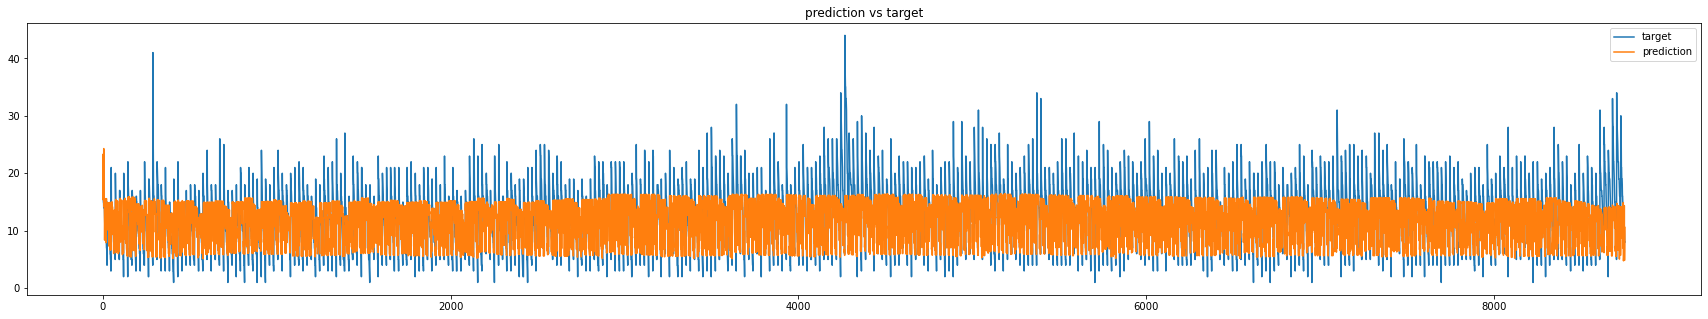

In [22]:
plt.figure(figsize=(30,5))
plt.title("prediction vs target")
plt.plot(y_test , label='target')
plt.plot(test_preds, label='prediction')
plt.legend()

# Feature Importance

In [23]:
# Find feature importance of our best model
ideal_model.feature_importances_


array([0.00826678, 0.06338765, 0.00212136, 0.02499549, 0.05953804,
       0.84169068])

In [24]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

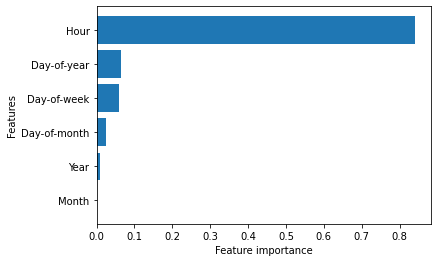

In [25]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [45]:
df["Day-of-week"].value_counts()

4    90089
3    88014
5    87528
2    87504
0    86936
1    86762
6    82473
Name: Day-of-week, dtype: int64

In [46]:
df["Hour"].value_counts()

17    34042
16    33181
18    33142
13    33075
15    32925
14    32693
12    32239
19    31264
11    31218
10    29646
20    29620
21    27665
9     27562
8     24604
22    24565
23    22058
7     20133
0     19835
1     18040
6     16304
2     16236
3     13272
5     13208
4     12779
Name: Hour, dtype: int64

# What Next

### We should add more features in our database like weather. Because weather conditions have effect on happening accident and amount of call to 911

### These features can be very helpful to increase our result:
  - temperature of every day
  - wind 
  - humidity 
  - ...
  